In [183]:
import os, sys
import glob
import json
import re

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.colors as clr

from scipy import stats
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import chi2_contingency, fisher_exact, barnard_exact


sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *
import analysis_utils as utils

In [3]:
# Sourced for aggregating data across subjects
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')
behavioral_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/') # where we will write our data

## Define function for extracting phonemes

In [4]:
import nltk
from functools import lru_cache
from itertools import product as iterprod

try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

## Load subject-level results

In [208]:
import nltk
from functools import lru_cache
from itertools import product as iterprod

try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

def compare_wrong_phonemes(responses, ground_truth, n_phones=1):
    '''
    Find match of first n_phonemes to the ground truth
    '''

    # Grab ground truth phoneme
    ground_truth_phoneme = wordbreak(ground_truth)[0][:n_phones]

    # Get first phoneme of each response
    predicted_phoneme = [wordbreak(word)[0][:n_phones] for word in responses]
    unique, counts = np.unique(predicted_phoneme, return_counts=True)

    # Find accuracy of first letter
    phoneme_accuracy = np.asarray([phone == ground_truth_phoneme for phone in predicted_phoneme])

    # Focus on wrong responses
    wrong_responses = np.argwhere(responses != ground_truth)

    # Make sure there is at least 1 wrong response
    if len(wrong_responses) >= 1:

        # Extract the wrong response phonemes and accompanying accuracy
        wrong_phonemes = np.asarray(predicted_phoneme)[wrong_responses]
        wrong_accuracy = phoneme_accuracy[wrong_responses]

        # Get number of correct responses for the wrong response
        wrong_resp_correct = np.sum(wrong_accuracy)
        wrong_resp_incorrect = len(wrong_accuracy) - wrong_resp_correct
        wrong_resp_accuracy = wrong_resp_correct / len(wrong_accuracy)
    else:
        wrong_resp_correct = np.nan 
        wrong_resp_incorrect = np.nan 
        wrong_resp_accuracy = np.nan

    return wrong_resp_correct, wrong_resp_incorrect, wrong_resp_accuracy


def get_leakage_stats(df_cleaned_behavior):

    df_stack = []
    columns = ['wrong_resp_n_correct', 'wrong_resp_n_incorrect', 'wrong_response_accuracy']

    for (task, word_index), df_task in df_cleaned_behavior.groupby(['task', 'word_index']): 

        _df = []

        # Go through each modality and get the stats
        for modality, df in df_task.groupby('modality'):

            ground_truth = df['ground_truth'].unique()[0]
            ground_truth_phoneme = wordbreak(ground_truth)[0][0]

            responses = df['response'].to_numpy()

            # get phoneme statistics
            df.loc[:, columns] = get_leakage_phoneme_match(responses, ground_truth, n_phones=1)
            _df.append(df)

        # Conduct stats now that we have both modalities
        _df = pd.concat(_df).reset_index(drop=True)

    # Create a contingency table
    contingency = _df[['wrong_resp_correct', 'wrong_resp_incorrect']].to_numpy().astype(float)

    if np.isnan(contingency).any():
        results = barnard_exact(contingency, alternative='greater')
        statistic, pvalue = results.statistic, results.pvalue
    else:
        

    # results = fisher_exact(contingency, alternative='greater')
    # results = chi2_contingency((contingency + 1))
    results = barnard_exact(contingency, alternative='greater')

    df_pvals.loc[len(df_pvals)] = {
        'task': task,
        'word_index': word_index,
        'stat': results.statistic,
        'pval': results.pvalue
    }
    df_stack = pd.concat(df_stack).reset_index(drop=True)

    ### Now conduct stats on it --> groupby word index within task modality 
    return df_stack
        



In [206]:
# Load results
df_results = pd.read_csv(os.path.join(behavioral_dir, f'all-task_subject-behavior_lemmatized.csv'))

# Create dataframe for evaluating leakage
df_leakage = pd.DataFrame(columns=[
        'task', 'modality', 'word_index', 
        'wrong_resp_correct', 'wrong_resp_incorrect', 'wrong_resp_accuracy', # focusing on the wrong responses, how many were correct v. incorrect
        
])

for (task, modality, word_index), df in df_results.groupby(['task', 'modality', 'word_index']):

    ground_truth = df['ground_truth'].unique()[0]
    ground_truth_phoneme = wordbreak(ground_truth)[0][0]

    responses = df['response'].to_numpy()

    # get phoneme statistics
    wrong_resp_correct, wrong_resp_incorrect, wrong_resp_accuracy = get_leakage_phoneme_match(responses, ground_truth, n_phones=1)


    df_leakage.loc[len(df_leakage)] = {
        'task': task,
        'modality': modality,
        'word_index': word_index,
        'wrong_resp_correct': wrong_resp_correct,
        'wrong_resp_incorrect': wrong_resp_incorrect,
        'wrong_resp_accuracy': wrong_resp_accuracy,
    }

## Calculate leakage statistics

For each predicted word, create a contingency table of (audio v. text) x (correct v. incorrect) specifically for the wrong responses.

In [202]:
all_pvals = []
df_pvals = pd.DataFrame(columns=['task', 'word_index', 'stat', 'pval'])

for (task, word_index), df in df_leakage.groupby(['task', 'word_index']):

    contingency = df[['wrong_resp_correct', 'wrong_resp_incorrect']].to_numpy().astype(float)

    if np.isnan(contingency).any():
        continue


    # results = fisher_exact(contingency, alternative='greater')
    # results = chi2_contingency((contingency + 1))
    results = barnard_exact(contingency, alternative='greater')

    df_pvals.loc[len(df_pvals)] = {
        'task': task,
        'word_index': word_index,
        'stat': results.statistic,
        'pval': results.pvalue
    }

In [200]:
def fishers_method(p_values):
    """
    Perform Fisher's method to combine p-values from multiple tests.
    
    Parameters:
    p_values (list or numpy array): A list of p-values from independent tests
    
    Returns:
    tuple: (combined_statistic, combined_p_value)
        - combined_statistic: Chi-squared statistic from the combined tests
        - combined_p_value: Overall significance of the combined tests
    """
    # Validate input
    if not isinstance(p_values, (list, np.ndarray)):
        raise TypeError("Input must be a list or numpy array of p-values")
    
    # Check for valid p-values (between 0 and 1)
    if any((p < 0 or p > 1) for p in p_values):
        raise ValueError("P-values must be between 0 and 1")
    
    # Calculate the combined chi-squared statistic
    # Fisher's method: -2 * sum(ln(p-values))
    combined_statistic = -2 * np.sum(np.log(p_values))
    
    # Degrees of freedom = 2 * number of tests
    degrees_of_freedom = 2 * len(p_values)
    
    # Calculate the combined p-value
    combined_p_value = 1 - stats.chi2.cdf(combined_statistic, degrees_of_freedom)
    
    return combined_statistic, combined_p_value

In [203]:
from statsmodels.stats.multitest import multipletests

for i, df in df_pvals.groupby('task'):
    # results = stats.ttest_1samp(df['stat'], 0, alternative='greater')
    pvalues = df['pval'].to_numpy()
    test_stat = df['stat'].to_numpy()

    pvalues = multipletests(pvalues, method='fdr_bh')[1]
    stat, pval = fishers_method(pvalues)
    print (f'Task {i} -- {pval}')

Task black -- 0.0
Task howtodraw -- 1.0
Task wheretheressmoke -- 0.99999999923183


### Plot phoneme accuracy across tasks

Text(0.5, 1.05, 'Phoneme accuracy across tasks')

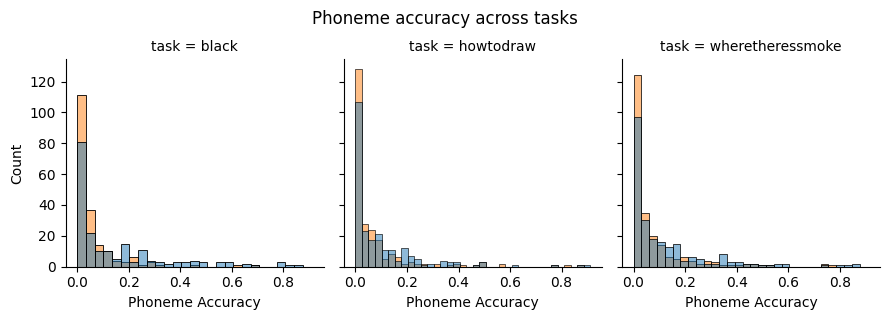

In [99]:
g = sns.FacetGrid(df_leakage, col="task")
g.map_dataframe(sns.histplot, x="wrong_resp_accuracy", hue='modality')

g.set_axis_labels("Phoneme Accuracy", "Count")
plt.suptitle('Phoneme accuracy across tasks', y=1.05)

### Calculate percentage of words with significant leakage

In [100]:
print (f'Percent significant leakage\n')

percent_leakage = []

for i, df in df_pvals.groupby('task'):
    perc = 100 * (sum(df['pval'] < 0.05) / len(df))
    print (f'Task: {i} -- {perc:.2f}%')
    percent_leakage.append(perc)

Percent significant leakage

Task: black -- 18.65%
Task: howtodraw -- 6.30%
Task: wheretheressmoke -- 10.21%


### Plot distribution of leakage p-values

Text(0.5, 1.05, 'Fisher Exact - Pvals')

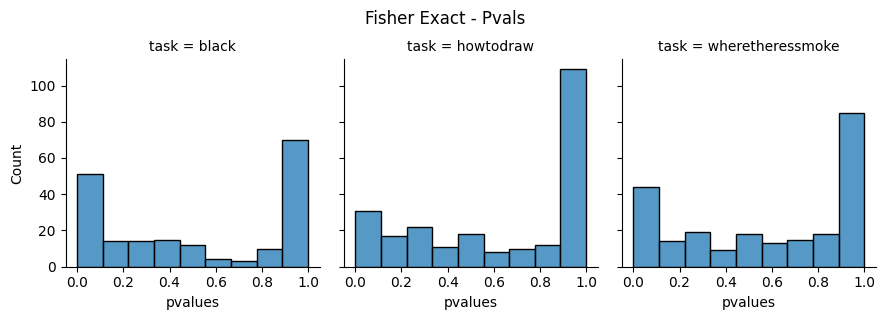

In [94]:
g = sns.FacetGrid(df_pvals, col="task")
g.map_dataframe(sns.histplot, x="pval")

g.set_axis_labels("pvalues", "Count")
plt.suptitle('Fisher Exact - Pvals', y=1.05)

### Load group data and re-evaluate with control

In [254]:
# Load results
df_results = pd.read_csv(os.path.join(behavioral_dir, 'all-task_group-analyzed-behavior_human-lemmatized.csv'))

pval_filter = df_pvals['pval'] >= 0.05
df_pval_filter = df_pvals.loc[pval_filter]

df_results_filtered = []

for i, df in df_results.groupby('task'):

    word_indices = df_pval_filter[df_pval_filter['task'] == i]['word_index']

    df = df[df['word_index'].isin(word_indices)]
    df_results_filtered.append(df)

df_results_filtered = pd.concat(df_results_filtered).reset_index(drop=True)


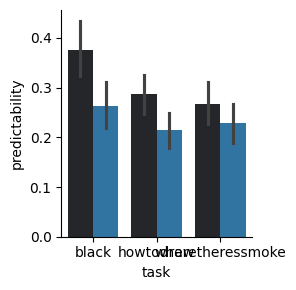

In [265]:
g = sns.FacetGrid(df_results_filtered)
g.map_dataframe(sns.barplot, x='task', y="predictability", hue='modality')

# g.set_axis_labels("pvalues", "Count")
# plt.suptitle('Fisher Exact - Pvals', y=1.05)